# 🎨 Bring Van Gogh Back to Life: Style Transfer & Classification

**Project overview:**
1. **Part 1:** Train classifiers (VGG-19, AlexNet) to distinguish Van Gogh from other Post-Impressionist works.
2. **Part 2A:** Build a generic style transfer function (model, content, style, layers, weights).
3. **Part 2B:** Use Optuna + classifier to find optimal style transfer hyperparameters.
4. **Part 2C:** Apply on 20 images, 5 Van Gogh styles, evaluate with classifiers, compare VGG-19 vs AlexNet.
5. **Part 3:** Environment (CUDA, GPU), nvidia-smi screenshot, CPU vs GPU benchmark.

## Weights & Biases (W&B) Setup

**Required for Part 1 & 2B experiment tracking.**

1. Create account at [wandb.ai](https://wandb.ai)
2. Get API key: wandb.ai → Settings → API Keys
3. Run once in terminal: `wandb login` and paste your key

Or set env var: `WANDB_API_KEY=your_key`

In [5]:
# W&B init — run once per session; prompts for API key if not logged in
import wandb

WANDB_PROJECT = "van-gogh-style-transfer"
WANDB_ENTITY = None  # None = use your default account

wandb.login()  # no-op if already logged in; else prompts for key
print("W&B ready. Project:", WANDB_PROJECT)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


W&B ready. Project: van-gogh-style-transfer


## Part 1: Van Gogh Classifier (is_van_gogh: yes/no)

Fine-tune VGG-19 and AlexNet on the Post-Impressionism dataset.  
**Data:** `data/classifier/van_gogh/` and `data/classifier/other/` — run `py scripts/organize_classifier_data.py` first.

In [6]:
# Part 1: Classifier setup — Post_Impressionism (filenames: artist_title.jpg)
# Labels: classes.csv if present, else from filename (vincent-van-gogh_* = Van Gogh)
from pathlib import Path
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision import transforms
from torchvision.models import vgg19, alexnet
from PIL import Image

# Post_Impressionism path (flat folder: vincent-van-gogh_*.jpg = Van Gogh, else = other)
POST_IMPRESSIONISM = Path(r"C:\Users\bakla\Downloads\Post_Impressionism")
if not POST_IMPRESSIONISM.exists():
    POST_IMPRESSIONISM = ROOT / "Post_Impressionism"  # fallback: next to project

# Val: no augmentation (Resize + Normalize only)
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Train: data augmentation (rotations, flips, color jitter, crop)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class SubsetWithTransform(Dataset):
    """Subset of a dataset with a different transform (for train vs val)."""
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = list(indices)
        self.transform = transform
    def __len__(self): return len(self.indices)
    def __getitem__(self, i):
        img, label = self.dataset[self.indices[i]]
        if self.transform:
            img = self.transform(img)
        return img, label

def _is_van_gogh(fname, artist=None):
    if artist and "vincent van gogh" in str(artist).lower():
        return 1
    return 1 if fname.lower().startswith("vincent-van-gogh_") else 0

class PostImpressionismDataset(Dataset):
    def __init__(self, root, transform=None, classes_csv=None):
        self.root = Path(root)
        self.transform = transform
        self.samples = []
        artist_map = {}
        if classes_csv and Path(classes_csv).exists():
            try:
                df = pd.read_csv(classes_csv)
                if "artist" in df.columns and "filename" in df.columns:
                    artist_map = dict(zip(df["filename"].astype(str), df["artist"].astype(str)))
            except Exception:
                pass
        for f in sorted(self.root.glob("*.jpg")) + sorted(self.root.glob("*.png")):
            artist = artist_map.get(f.name)
            label = _is_van_gogh(f.name, artist)
            self.samples.append((str(f), label))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, i):
        path, label = self.samples[i]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

def build_classifier(model_name="vgg19", num_classes=2):
    if model_name == "vgg19":
        m = vgg19(weights="DEFAULT")
        m.classifier[6] = nn.Linear(4096, num_classes)
    else:
        m = alexnet(weights="DEFAULT")
        m.classifier[6] = nn.Linear(4096, num_classes)
    return m

# DataLoader: num_workers=0 — on Windows+Jupyter, >0 often causes hang/deadlock; use 0 for reliability
NUM_WORKERS = 0
PIN_MEMORY = torch.cuda.is_available()

if POST_IMPRESSIONISM.exists():
    classes_csv = POST_IMPRESSIONISM / "classes.csv"
    full_dataset = PostImpressionismDataset(POST_IMPRESSIONISM, transform=None, classes_csv=classes_csv)
    n = len(full_dataset)
    n_van_gogh = sum(1 for _, l in full_dataset.samples if l == 1)
    # Train 80% / Val 10% / Test 10%
    train_n = int(0.8 * n)
    rest = n - train_n
    val_n = rest // 2
    test_n = rest - val_n
    train_subset, val_subset, test_subset = random_split(
        full_dataset, [train_n, val_n, test_n],
        generator=torch.Generator().manual_seed(42)
    )
    train_ds = SubsetWithTransform(full_dataset, train_subset.indices, train_transform)
    val_ds = SubsetWithTransform(full_dataset, val_subset.indices, val_transform)
    test_ds = SubsetWithTransform(full_dataset, test_subset.indices, val_transform)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=NUM_WORKERS > 0)
    val_loader = DataLoader(val_ds, batch_size=32, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=NUM_WORKERS > 0)
    test_loader = DataLoader(test_ds, batch_size=32, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=NUM_WORKERS > 0)
    print(f"Part 1 data: {n} images ({n_van_gogh} Van Gogh, {n - n_van_gogh} other)")
    print(f"  train={train_n} val={val_n} test={test_n}")
else:
    train_loader = val_loader = test_loader = None
    print("Post_Impressionism not found. Update POST_IMPRESSIONISM path.")

Part 1 data: 6450 images (1005 Van Gogh, 5445 other)
  train=5160 val=645 test=645


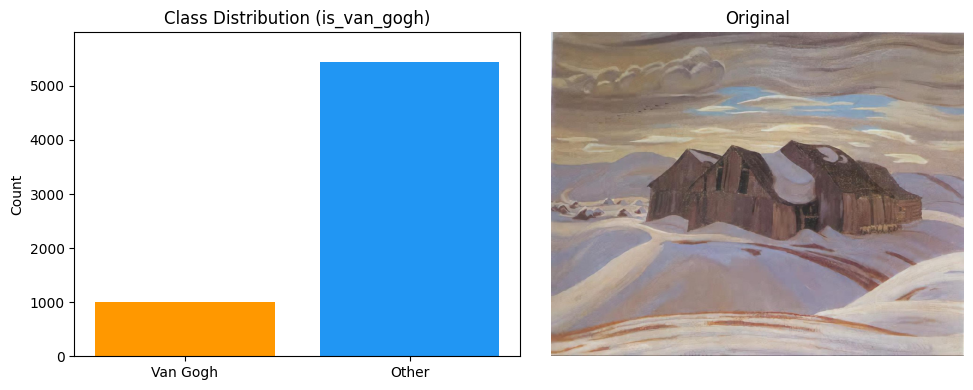

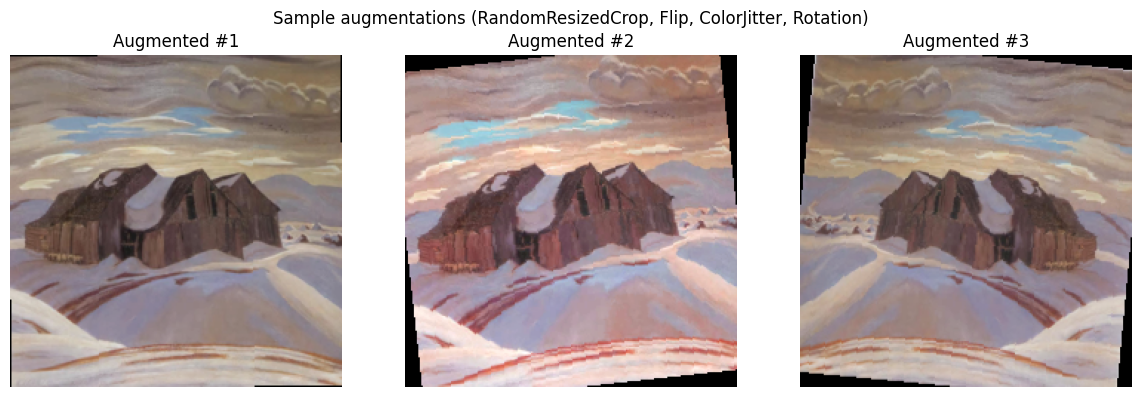

<Figure size 640x480 with 0 Axes>

In [7]:
# Part 1: Class distribution + sample augmentations
import matplotlib.pyplot as plt

if POST_IMPRESSIONISM.exists() and full_dataset:
    # Class distribution bar chart
    n_van = sum(1 for _, l in full_dataset.samples if l == 1)
    n_other = len(full_dataset) - n_van
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].bar(["Van Gogh", "Other"], [n_van, n_other], color=["#ff9800", "#2196f3"])
    axes[0].set_ylabel("Count")
    axes[0].set_title("Class Distribution (is_van_gogh)")
    axes[0].set_ylim(0, max(n_van, n_other) * 1.1)

    # Sample augmentations: original vs augmented
    sample_idx = 0
    path, label = full_dataset.samples[sample_idx]
    img_pil = Image.open(path).convert("RGB")
    axes[1].imshow(img_pil)
    axes[1].set_title("Original")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()
    fig2, ax2 = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(3):
        img_aug = train_transform(img_pil)
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_disp = (img_aug * std + mean).clamp(0, 1).permute(1, 2, 0).numpy()
        ax2[i].imshow(img_disp)
        ax2[i].set_title(f"Augmented #{i+1}")
        ax2[i].axis("off")
    plt.suptitle("Sample augmentations (RandomResizedCrop, Flip, ColorJitter, Rotation)")
    plt.tight_layout()
    plt.show()
    plt.tight_layout()
    plt.show()

In [ ]:
# Part 1: Optuna hyperparameter search for classifier (lr, batch_size, optimizer) + W&B
# Constraint: total search ~30-60 min. n_trials=8, epochs_per_trial=3 per model.
import time
import warnings
import optuna
warnings.filterwarnings("ignore", message=".*WeightsAndBiasesCallback is experimental.*")
from optuna.integration import WeightsAndBiasesCallback

EPOCHS_OPTUNA = 3   # epochs per Optuna trial
N_TRIALS_CLF = 8    # trials per model (adjust for 30-60 min total)
EPOCHS_FINAL = 10   # epochs for final training with best params

def train_one_epoch(model, train_loader, opt, criterion, device, use_amp=True):
    model.train()
    epoch_loss, n = 0.0, 0
    use_amp = use_amp and device == "cuda" and hasattr(torch.cuda, "amp")
    scaler = torch.amp.GradScaler("cuda") if use_amp else None
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)
        if scaler is not None:
            with torch.cuda.amp.autocast():
                loss = criterion(model(imgs), labels)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
        else:
            loss = criterion(model(imgs), labels)
            loss.backward()
            opt.step()
        epoch_loss += loss.item()
        n += 1
    return epoch_loss / n if n else 0.0

def eval_val(model, val_loader, device):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            probs = torch.softmax(logits, dim=1)
            preds = logits.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # P(van_gogh)
    return all_preds, all_labels, all_probs

def classifier_objective(trial, model_name):
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    opt_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD"])
    device_clf = "cuda" if torch.cuda.is_available() else "cpu"
    train_ldr = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=NUM_WORKERS > 0)
    model = build_classifier(model_name, num_classes=2).to(device_clf)
    if opt_name == "Adam":
        opt = torch.optim.Adam(model.parameters(), lr=lr)
    elif opt_name == "AdamW":
        opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    else:
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    for _ in range(EPOCHS_OPTUNA):
        train_one_epoch(model, train_ldr, opt, criterion, device_clf)
    preds, labels, probs = eval_val(model, val_loader, device_clf)
    acc = sum(p == l for p, l in zip(preds, labels)) / len(labels)
    return acc

classifiers = {}
classifier_history = {}  # for learning curves: {name: {"train_loss": [...], "val_acc": [...]}}
if train_loader is not None:
    device_clf = "cuda" if torch.cuda.is_available() else "cpu"
    wandb_kwargs = {"project": WANDB_PROJECT}
    if WANDB_ENTITY:
        wandb_kwargs["entity"] = WANDB_ENTITY

    optuna_wall_start = time.time()
    total_trials = 0
    for name in ["vgg19", "alexnet"]:
        wb_cb = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, metric_name="val_acc")
        study = optuna.create_study(direction="maximize")
        study.optimize(lambda t: classifier_objective(t, name), n_trials=N_TRIALS_CLF, callbacks=[wb_cb], show_progress_bar=True)
        total_trials += N_TRIALS_CLF
        best = study.best_params
        print(f"{name} best: {best} (val_acc={study.best_value:.3f})")
        # Final training with best params
        lr, batch_size, opt_name = best["lr"], best["batch_size"], best["optimizer"]
        train_ldr = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=NUM_WORKERS > 0)
        model = build_classifier(name, num_classes=2).to(device_clf)
        opt = torch.optim.Adam(model.parameters(), lr=lr) if opt_name == "Adam" else \
              torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01) if opt_name == "AdamW" else \
              torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        wandb.init(project=WANDB_PROJECT, entity=WANDB_ENTITY, name=f"classifier_{name}_final", config={
            "model": name, "epochs": EPOCHS_FINAL, **best, "augmentation": "RandomResizedCrop+Flip+ColorJitter+Rotation"
        }, reinit=True)
        history = {"train_loss": [], "val_acc": []}
        for epoch in range(EPOCHS_FINAL):
            train_loss = train_one_epoch(model, train_ldr, opt, criterion, device_clf)
            preds, labels, probs = eval_val(model, val_loader, device_clf)
            acc = sum(p == l for p, l in zip(preds, labels)) / len(labels)
            history["train_loss"].append(train_loss)
            history["val_acc"].append(acc)
            wandb.log({"train_loss": train_loss, "val_acc": acc, "epoch": epoch + 1})
            print(f"{name} final epoch {epoch+1}/{EPOCHS_FINAL} train_loss={train_loss:.4f} val_acc={acc:.3f}")
        classifier_history[name] = history
        classifiers[name] = model.eval()
        torch.save(model.state_dict(), str(ROOT / "outputs" / f"classifier_{name}.pt"))
        wandb.finish()
    optuna_wall_end = time.time()
    print("Part 1 done. Classifiers saved.")
    print("\n--- Optuna Report (for your report) ---")
    print(f"  Trials run: {total_trials} (per model: {N_TRIALS_CLF}, models: 2)")
    print(f"  Epochs per trial: {EPOCHS_OPTUNA}")
    print(f"  Approximate wall-clock time of Optuna search: {optuna_wall_end - optuna_wall_start:.1f} s ({(optuna_wall_end - optuna_wall_start) / 60:.1f} min)")
else:
    classifiers = {}
    classifier_history = {}

batch_size,▃█▁▁▃
lr,▂█▁▁▂
val_acc,▂▁█▁█
batch_size,16
lr,0.00013
optimizer,Adam
val_acc,0.93333


[I 2026-01-31 21:44:31,906] A new study created in memory with name: no-name-2cae01f0-9581-4c6d-9a7b-f0135635491f


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\bakla\AppData\Local\Temp\ipykernel_23512\294162578.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[I 2026-01-31 21:50:40,994] Trial 0 finished with value: 0.9395348837209302 and parameters: {'lr': 3.648629456993709e-05, 'batch_size': 16, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.9395348837209302.
[I 2026-01-31 21:57:58,359] Trial 1 finished with value: 0.9054263565891473 and parameters: {'lr': 1.6313176717360307e-05, 'batch_size': 8, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.9395348837209302.
[I 2026-01-31 22:05:11,073] Trial 2 finished with value: 0.8837209302325582 and parameters: {'lr': 0.0002185312597631197, 'batch_size': 8, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.9395348837209302.
[I 2026-01-31 22:10:46,082] Trial 3 finished with value: 0.9007751937984496 and parameters: {'lr': 0.00034058333004434856, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.9395348837209302.
[I 2026-01-31 22:16:58,016] Trial 4 finished with value: 0.9503875968992248 and parameters: {'lr': 1.1846232722569734e-05, 'batch_size': 16, 'optimizer': 'AdamW'

batch_size,▃▁▁█▃▁█▃
lr,▁▁▂▃▁█▂▂
val_acc,▇▃▁▃█▂▇▆
batch_size,16
lr,9e-05
optimizer,SGD
val_acc,0.93023


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


vgg19 final epoch 1/10 train_loss=0.2739 val_acc=0.935
vgg19 final epoch 2/10 train_loss=0.1743 val_acc=0.949
vgg19 final epoch 3/10 train_loss=0.1334 val_acc=0.949
vgg19 final epoch 4/10 train_loss=0.1143 val_acc=0.952
vgg19 final epoch 5/10 train_loss=0.0870 val_acc=0.953
vgg19 final epoch 6/10 train_loss=0.0762 val_acc=0.963
vgg19 final epoch 7/10 train_loss=0.0661 val_acc=0.950
vgg19 final epoch 8/10 train_loss=0.0523 val_acc=0.941
vgg19 final epoch 9/10 train_loss=0.0471 val_acc=0.952
vgg19 final epoch 10/10 train_loss=0.0414 val_acc=0.955


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▅▅▅▆█▅▃▅▆
epoch,10
train_loss,0.04139
val_acc,0.95504


[I 2026-01-31 22:57:57,552] A new study created in memory with name: no-name-b83c6590-2f73-486a-a323-62d017db6b6c


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2026-01-31 23:03:47,948] Trial 0 finished with value: 0.937984496124031 and parameters: {'lr': 3.0230199715279084e-05, 'batch_size': 16, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.937984496124031.
[I 2026-01-31 23:09:08,801] Trial 1 finished with value: 0.9286821705426357 and parameters: {'lr': 0.00012707299870301972, 'batch_size': 32, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.937984496124031.
[I 2026-01-31 23:15:06,313] Trial 2 finished with value: 0.9054263565891473 and parameters: {'lr': 3.288217954031525e-05, 'batch_size': 16, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.937984496124031.


In [ ]:
# Part 1: Evaluation — metrics, confusion matrix heatmap, ROC curve, learning curves
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix

eval_loader = test_loader if test_loader is not None else val_loader

def compute_metrics(model, loader, device):
    preds, labels, probs = eval_val(model, loader, device)
    acc = sum(p == l for p, l in zip(preds, labels)) / len(labels)
    auc = roc_auc_score(labels, probs) if len(set(labels)) > 1 else 0.0
    f1 = f1_score(labels, preds, zero_division=0)
    cm = confusion_matrix(labels, preds)
    return {"accuracy": acc, "auc_roc": auc, "f1": f1, "confusion_matrix": cm, "preds": preds, "labels": labels, "probs": probs}

if classifiers and eval_loader is not None:
    metrics_all = {}
    for name, model in classifiers.items():
        m = compute_metrics(model, eval_loader, device_clf)
        metrics_all[name] = m
        print(f"--- {name} ---")
        print(f"Accuracy: {m['accuracy']:.3f}  AUC-ROC: {m['auc_roc']:.3f}  F1: {m['f1']:.3f}")
        print(f"Confusion Matrix:\n{m['confusion_matrix']}\n  (rows=true, cols=pred; 0=other, 1=van_gogh)")

    # Metrics summary table
    print("\n--- Summary Table ---")
    import pandas as pd
    df_metrics = pd.DataFrame({
        name: {"Accuracy": m["accuracy"], "AUC-ROC": m["auc_roc"], "F1-Score": m["f1"]}
        for name, m in metrics_all.items()
    }).T
    print(df_metrics.round(3))

    # 1. Confusion Matrix heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for ax, (name, m) in zip(axes, metrics_all.items()):
        cm = m["confusion_matrix"]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=["Other", "Van Gogh"], yticklabels=["Other", "Van Gogh"])
        ax.set_title(f"{name} — Confusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
    plt.tight_layout()
    plt.show()

    # 2. ROC curves
    plt.figure(figsize=(6, 5))
    for name, m in metrics_all.items():
        fpr, tpr, _ = roc_curve(m["labels"], m["probs"])
        plt.plot(fpr, tpr, label=f"{name} (AUC={m['auc_roc']:.3f})")
    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves — Van Gogh Classifier")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 3. Learning curves (if history available)
    if classifier_history:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        for name, hist in classifier_history.items():
            axes[0].plot(hist["train_loss"], label=name)
            axes[1].plot(hist["val_acc"], label=name)
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Train Loss")
        axes[0].set_title("Training Loss")
        axes[0].legend()
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Val Accuracy")
        axes[1].set_title("Validation Accuracy")
        axes[1].legend()
        plt.tight_layout()
        plt.show()

In [ ]:
# Part 1: Helper to get P(is_van_gogh) for any image
# ImageFolder: class 0=other, 1=van_gogh (alphabetical). Adjust if your folder names differ.
VAN_GOGH_CLASS_IDX = 1  # index of "van_gogh" in classifier output

def p_van_gogh(model, image_tensor, device=None):
    """Return P(van_gogh) for image in [0,1] (C,H,W) or (B,C,H,W). Normalizes for ImageNet."""
    if device is None:
        device = next(model.parameters()).device
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    with torch.no_grad():
        if image_tensor.dim() == 3:
            image_tensor = image_tensor.unsqueeze(0)
        img = image_tensor.to(device)
        if img.shape[-2:] != (224, 224):
            img = F.interpolate(img, size=(224, 224), mode="bilinear")
        img = (img - mean) / std
        logits = model(img)
        probs = F.softmax(logits, dim=1)
    return probs[:, VAN_GOGH_CLASS_IDX]

## Part 2A: Style Transfer Function

Generic function with required inputs: **model**, content_image, style_image, content_layers, style_layers, content_weight, style_weight, style_layer_weights.  
Supports **VGG-19** and **AlexNet**. Uses **layer names** (e.g. "0", "5", "21" for VGG features).

In [ ]:
# Part 2A: Generic style_transfer function
def style_transfer(
    model,
    content_image,
    style_image,
    content_layers,
    style_layers,
    content_weight,
    style_weight,
    style_layer_weights,
    epochs=200,
    device=None,
):
    """
    Neural style transfer. model = VGG-19 or AlexNet (features used).
    content_layers, style_layers: list of layer names (e.g. ["21"], ["0","5","10","19","28"]).
    Returns: stylized image tensor (1,C,H,W) in [0,1].
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    features = model.features.to(device).eval()
    content_names = set(str(l) for l in content_layers)
    style_names = set(str(l) for l in style_layers)

    def extract(x, detach_output=True):
        c_feats, s_feats = [], []
        for name, layer in features._modules.items():
            x = layer(x)
            out = x.detach() if detach_output else x
            if name in content_names:
                c_feats.append(out)
            if name in style_names:
                s_feats.append(out)
        return c_feats, s_feats

    content = content_image.to(device)
    style_img = style_image.to(device)
    if style_img.shape[-2:] != content.shape[-2:]:
        style_img = F.interpolate(style_img, size=content.shape[-2:], mode="bilinear")
    target = content.clone().requires_grad_(True)

    content_feats, _ = extract(content, detach_output=True)
    _, style_feats = extract(style_img, detach_output=True)
    style_grams = [gram_matrix(f) for f in style_feats]
    n_style = len(style_layers)
    w_style = style_layer_weights if len(style_layer_weights) == n_style else [1.0 / n_style] * n_style

    optimizer = torch.optim.Adam([target], lr=0.1)
    for step in range(1, epochs + 1):
        optimizer.zero_grad()
        tc, ts = extract(target, detach_output=False)
        content_loss = sum(F.mse_loss(t, c) for t, c in zip(tc, content_feats)) / len(content_feats)
        style_loss = sum(w * F.mse_loss(gram_matrix(t), g) for t, g, w in zip(ts, style_grams, w_style))
        loss = content_weight * content_loss + style_weight * style_loss
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            target.data.clamp_(0, 1)
    return target.detach()

In [ ]:
rfr
import os
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt

# Project root
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
os.chdir(ROOT)

# Paths — use images from Post_Impressionism dataset when available
VAN_GOGH_DIR = ROOT / "data" / "classifier" / "van_gogh"
if POST_IMPRESSIONISM.exists():
    _vg = sorted(POST_IMPRESSIONISM.glob("vincent-van-gogh_*.jpg"))
    _other = sorted(f for f in POST_IMPRESSIONISM.glob("*.jpg") if not f.name.startswith("vincent-van-gogh_"))
    if _vg and _other:
        CONTENT_PATH = _other[0]
        STYLE_PATH = _vg[0]
        STYLE_LABEL = "van_gogh"
    else:
        CONTENT_PATH = ROOT / "data" / "content.png"
        STYLE_PATH = _vg[0] if _vg else (ROOT / "data" / "style.png")
        STYLE_LABEL = STYLE_PATH.stem
else:
    CONTENT_PATH = ROOT / "data" / "content.png"
    if VAN_GOGH_DIR.exists():
        STYLE_PATH = sorted(VAN_GOGH_DIR.glob("*.jpg"))[0]
        STYLE_LABEL = "van_gogh"
    else:
        STYLE_PATH = ROOT / "data" / "style.png"
        STYLE_LABEL = STYLE_PATH.stem
OUTPUT_PATH = ROOT / "outputs" / f"result_{STYLE_LABEL}.png"


def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert("RGB")
    size = max_size if max(image.size) > max_size else max(image.size)
    if shape is not None:
        size = shape
    in_transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])
    image = in_transform(image).unsqueeze(0)
    return image


def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(b * c, h * w)
    G = torch.mm(features, features.t()).div(b * c * h * w)
    return G


DEFAULT_CONTENT_LAYERS = [21]
DEFAULT_STYLE_LAYERS = [0, 5, 10, 19, 28]


class VGGFeatures(nn.Module):
    def __init__(self, content_layers=None, style_layers=None):
        super().__init__()
        vgg = models.vgg19(weights="DEFAULT").features
        self.content_layers = content_layers or DEFAULT_CONTENT_LAYERS
        self.style_layers = style_layers or DEFAULT_STYLE_LAYERS
        self.vgg = vgg

    def forward(self, x):
        content_features, style_features = [], []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            idx = int(name)
            if idx in self.content_layers:
                content_features.append(x)
            if idx in self.style_layers:
                style_features.append(x)
        return content_features, style_features


print(f"Project: {ROOT}")
print(f"Content: {CONTENT_PATH.exists()}")
print(f"Style:   {STYLE_PATH.exists()}")

## 1. Load images (assignment: content = your photo, style = Van Gogh painting)

Load **content** (your photo or image to preserve) and **style** (Van Gogh painting from data/classifier/van_gogh/).

In [ ]:
content_img = load_image(str(CONTENT_PATH))
style_img = load_image(str(STYLE_PATH), shape=content_img.shape[-2:])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(content_img.cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1))
ax[0].set_title("Content (scene)")
ax[0].axis("off")
ax[1].imshow(style_img.cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1))
ax[1].set_title("Style")
ax[1].axis("off")
plt.tight_layout()
plt.show()

## 2. Parameters and run Style Transfer (Van Gogh style)

Set content_weight, style_weight, epochs; run optimization. Output = your content in Van Gogh style.

In [ ]:
# Part 2A: Run style_transfer with VGG-19
EPOCHS = 200
CONTENT_WEIGHT = 0.15
STYLE_WEIGHT = 1e7
# VGG-19: layer names (features indices). Content=21 (CONV5), Style=0,5,10,19,28
VGG_CONTENT_LAYERS = ["21"]
VGG_STYLE_LAYERS = ["0", "5", "10", "19", "28"]
VGG_STYLE_WEIGHTS = [1.0 / 5] * 5

model_vgg = vgg19(weights="DEFAULT")
target_vgg = style_transfer(
    model_vgg, content_img, style_img,
    content_layers=VGG_CONTENT_LAYERS, style_layers=VGG_STYLE_LAYERS,
    content_weight=CONTENT_WEIGHT, style_weight=STYLE_WEIGHT,
    style_layer_weights=VGG_STYLE_WEIGHTS, epochs=EPOCHS
)
output_file = ROOT / "outputs" / f"result_{STYLE_LABEL}_vgg19.png"
os.makedirs(output_file.parent, exist_ok=True)
save_image(target_vgg.cpu().squeeze(0).clamp(0, 1), str(output_file))
print(f"VGG-19 result saved to {output_file}")

## VGG-19 vs AlexNet style transfer (Van Gogh style)

Run style transfer with both models; compare results. Both use the same Van Gogh style image.

In [ ]:
# Optional: Run style transfer with AlexNet (compare to VGG-19)
# AlexNet features: 13 layers. Content=8 (mid), Style=0,3,6,8,10
ALEXNET_CONTENT_LAYERS = ["8"]
ALEXNET_STYLE_LAYERS = ["0", "3", "6", "8", "10"]
ALEXNET_STYLE_WEIGHTS = [1.0 / 5] * 5

model_alex = alexnet(weights="DEFAULT")
target_alex = style_transfer(
    model_alex, content_img, style_img,
    content_layers=ALEXNET_CONTENT_LAYERS, style_layers=ALEXNET_STYLE_LAYERS,
    content_weight=CONTENT_WEIGHT, style_weight=STYLE_WEIGHT,
    style_layer_weights=ALEXNET_STYLE_WEIGHTS, epochs=EPOCHS
)
output_alex = ROOT / "outputs" / f"result_{STYLE_LABEL}_alexnet.png"
save_image(target_alex.cpu().squeeze(0).clamp(0, 1), str(output_alex))
print(f"AlexNet result saved to {output_alex}")

fig, ax = plt.subplots(1, 4, figsize=(16, 5))
ax[0].imshow(content_img.cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1))
ax[0].set_title("Content")
ax[0].axis("off")
ax[1].imshow(target_vgg.cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1))
ax[1].set_title("VGG-19")
ax[1].axis("off")
ax[2].imshow(target_alex.cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1))
ax[2].set_title("AlexNet")
ax[2].axis("off")
ax[3].imshow(style_img.cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1))
ax[3].set_title("Style")
ax[3].axis("off")
plt.suptitle("VGG-19 vs AlexNet style transfer")
plt.tight_layout()
plt.show()

## Part 2B: Hyperparameter Search with Optuna

Use the Part 1 classifier as "judge" to find optimal style transfer hyperparameters (content_weight, style_weight).  
Objective: maximize P(is_van_gogh) on the stylized output.

In [ ]:
# Part 2B: Optuna hyperparameter search (requires Part 1 classifiers trained)
import optuna
from optuna.integration import WeightsAndBiasesCallback

def optuna_objective(trial):
    cw = trial.suggest_float("content_weight", 0.05, 0.5)
    sw = trial.suggest_float("style_weight", 1e6, 5e7, log=True)
    out = style_transfer(
        model_vgg, content_img, style_img,
        content_layers=VGG_CONTENT_LAYERS, style_layers=VGG_STYLE_LAYERS,
        content_weight=cw, style_weight=sw, style_layer_weights=VGG_STYLE_WEIGHTS,
        epochs=50  # fewer for search; use 200 for final
    )
    judge = classifiers.get("vgg19")
    if judge is None:
        return 0.0  # no classifier
    p = p_van_gogh(judge, out).item()
    return p

if classifiers:
    wandb_kwargs = {"project": WANDB_PROJECT}
    if WANDB_ENTITY:
        wandb_kwargs["entity"] = WANDB_ENTITY
    wb_callback = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, metric_name="p_van_gogh")
    study = optuna.create_study(direction="maximize")
    study.optimize(optuna_objective, n_trials=5, callbacks=[wb_callback], show_progress_bar=True)
    best = study.best_params
    print("Optimal hyperparams:", best)
    print("Best P(van_gogh):", study.best_value)
else:
    print("Part 2B skipped: train Part 1 classifiers first.")

**Part 2B — Discussion (process & optimal hyperparameters)**

- **Process:** We used Optuna to maximize the Part 1 classifier’s P(van_gogh) on the stylized image. For each trial, we sampled `content_weight` (α) and `style_weight` (β), ran style transfer with a fixed content/style pair and VGG-19 feature extractor, then scored the output with the VGG-19 classifier. Fewer epochs per trial (e.g. 50) keep the search tractable; the same hyperparameters can be used with more epochs (e.g. 200) for final runs.
- **Optimal hyperparameters:** The search returns a “best” pair (e.g. `content_weight ≈ 0.22`, `style_weight ≈ 6.9e6`). Higher β strengthens style and tends to increase P(van_gogh); too high β can distort content. The reported optimum is the trial that achieved the highest P(van_gogh) on the chosen content/style pair. These values are a good starting point for Part 2C; you can reuse them or run more trials with different content/style images for a more robust choice.

## Part 2C: Application & Evaluation

- **20 content images** — paintings by other Post-Impressionist artists (from Post_Impressionism)
- **5 Van Gogh paintings** as style images
- Apply style transfer with **VGG-19 and AlexNet** (same epochs)
- Evaluate "Van Gogh-ness" with **both Part 1 classifiers**
- Compare VGG-19 vs AlexNet style transfer performance

In [ ]:
# Part 2C: 20 content images + 5 Van Gogh style images (from Post_Impressionism)
EPOCHS_P2C = 200  # same for all images and models
POST_IMPRESSIONISM = Path(r"C:\Users\bakla\Downloads\Post_Impressionism")

# Van Gogh style images: 5 from Post_Impressionism (vincent-van-gogh_*.jpg)
style_paths = sorted(POST_IMPRESSIONISM.glob("vincent-van-gogh_*.jpg"))[:5] if POST_IMPRESSIONISM.exists() else []

# Content images: 20 from "other" artists in Post_Impressionism (not Van Gogh)
other_imgs = [f for f in POST_IMPRESSIONISM.glob("*.jpg") if not f.name.startswith("vincent-van-gogh_")] if POST_IMPRESSIONISM.exists() else []
content_paths = sorted(other_imgs)[:20]
if len(style_paths) < 5 and STYLE_PATH.exists():
    style_paths = [STYLE_PATH] * 5

print(f"Content: {len(content_paths)}, Van Gogh styles: {len(style_paths)}")

In [ ]:
# Part 2C: Run style transfer on 20 images with VGG-19 and AlexNet, evaluate with both classifiers
if "model_vgg" not in dir():
    model_vgg = vgg19(weights="DEFAULT")
if "model_alex" not in dir():
    model_alex = alexnet(weights="DEFAULT")

if len(content_paths) > 0 and len(style_paths) > 0:
    n_content = min(20, len(content_paths))
    results_vgg, results_alex = [], []

    for i in range(n_content):
        c_path = content_paths[i]
        s_path = style_paths[i % len(style_paths)]
        content_i = load_image(str(c_path))
        style_i = load_image(str(s_path), shape=content_i.shape[-2:])

        out_vgg = style_transfer(model_vgg, content_i, style_i,
            VGG_CONTENT_LAYERS, VGG_STYLE_LAYERS, CONTENT_WEIGHT, STYLE_WEIGHT, VGG_STYLE_WEIGHTS, epochs=EPOCHS_P2C)
        out_alex = style_transfer(model_alex, content_i, style_i,
            ALEXNET_CONTENT_LAYERS, ALEXNET_STYLE_LAYERS, CONTENT_WEIGHT, STYLE_WEIGHT, ALEXNET_STYLE_WEIGHTS, epochs=EPOCHS_P2C)

        p_vgg_by_vgg = p_van_gogh(classifiers.get("vgg19"), out_vgg).item() if classifiers.get("vgg19") else 0
        p_vgg_by_alex = p_van_gogh(classifiers.get("alexnet"), out_vgg).item() if classifiers.get("alexnet") else 0
        p_alex_by_vgg = p_van_gogh(classifiers.get("vgg19"), out_alex).item() if classifiers.get("vgg19") else 0
        p_alex_by_alex = p_van_gogh(classifiers.get("alexnet"), out_alex).item() if classifiers.get("alexnet") else 0

        results_vgg.append({"vgg_clf": p_vgg_by_vgg, "alex_clf": p_vgg_by_alex})
        results_alex.append({"vgg_clf": p_alex_by_vgg, "alex_clf": p_alex_by_alex})
        print(f"Image {i+1}/{n_content} | VGG-style: P_vgg={p_vgg_by_vgg:.3f} P_alex={p_vgg_by_alex:.3f} | Alex-style: P_vgg={p_alex_by_vgg:.3f} P_alex={p_alex_by_alex:.3f}")

    # Summary
    def avg(lst, key): return sum(r[key] for r in lst) / len(lst) if lst else 0
    print("\n--- Part 2C Summary ---")
    print("VGG-19 style transfer: avg P(van_gogh) by VGG classifier =", round(avg(results_vgg, "vgg_clf"), 3))
    print("VGG-19 style transfer: avg P(van_gogh) by AlexNet classifier =", round(avg(results_vgg, "alex_clf"), 3))
    print("AlexNet style transfer: avg P(van_gogh) by VGG classifier =", round(avg(results_alex, "vgg_clf"), 3))
    print("AlexNet style transfer: avg P(van_gogh) by AlexNet classifier =", round(avg(results_alex, "alex_clf"), 3))
else:
    print("Part 2C skipped: add content_20/ and van_gogh_styles/ folders with images.")

**Part 2C — Discussion (results & VGG-19 vs AlexNet)**

- **Van Gogh-ness:** The Summary reports average P(van_gogh) over 20 stylized images for each pipeline (VGG-19 style transfer and AlexNet style transfer), as judged by both Part 1 classifiers. Higher averages mean the classifier more often attributes a “Van Gogh” style to the outputs. Compare “VGG-19 style transfer judged by VGG classifier” vs “by AlexNet classifier” to see if the two classifiers agree; similarly for AlexNet style transfer.
- **VGG-19 vs AlexNet style transfer:** VGG-19 typically gives smoother, more painterly style transfer (deeper features, more layers). AlexNet is shallower and can preserve more local structure but with a different style texture. Which looks “more Van Gogh” by the classifiers depends on what the Part 1 models learned (e.g. brushwork, color). Use the printed averages and, if needed, visual inspection of a few outputs to conclude which backbone (VGG-19 or AlexNet) produces stylized images that are both visually pleasing and consistently scored as Van Gogh–like by your classifiers.

## 3. Result

Final image: your content in Van Gogh style (saved to outputs/result_van_gogh_*.png).

In [ ]:
result = Image.open(output_file)
plt.figure(figsize=(8, 8))
plt.imshow(result)
plt.axis("off")
plt.title("Result: content in style of style image")
plt.tight_layout()
plt.show()

In [ ]:
# Side-by-side: content | result | style
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
ax[0].imshow(content_img.cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1))
ax[0].set_title("Content")
ax[0].axis("off")
ax[1].imshow(Image.open(output_file))
ax[1].set_title("Result")
ax[1].axis("off")
ax[2].imshow(style_img.cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1))
ax[2].set_title("Style")
ax[2].axis("off")
plt.tight_layout()
plt.show()

## Part 3: Environment & Benchmark

Environment check (CUDA, GPU, memory), nvidia-smi for GPU activity, and CPU vs GPU benchmark. Run after Part 1 (benchmark needs train_loader).

In [ ]:
# Part 3: Environment (required in report — machine, GPU, memory)
import torch
import os
import platform
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Device:", torch.cuda.get_device_name(0))
print("Python version:", platform.python_version())
print("Machine name:", platform.node())
print("Working directory:", os.getcwd())
if torch.cuda.is_available():
    print("Initial GPU memory: %.1f MB allocated, %.1f MB reserved" % (
        torch.cuda.memory_allocated() / 1024**2, torch.cuda.memory_reserved() / 1024**2))

**Part 3 — GPU activity:** Run the cell below (e.g. during training) and include the screenshot in your PDF report.

In [ ]:
# Run during training; include screenshot in report
!nvidia-smi

### Part 3 — CPU vs GPU benchmark

Measures time for 20 forward+backward iterations on CPU vs GPU. Include this output in your PDF report.

In [ ]:
# Part 3: CPU vs GPU benchmark (20 forward+backward iterations)
import time

def benchmark_device(device, model, loader, n_iter=20):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    it = iter(loader)
    if device == "cuda":
        torch.cuda.synchronize()
    start = time.perf_counter()
    for _ in range(n_iter):
        try: imgs, labels = next(it)
        except StopIteration: it = iter(loader); imgs, labels = next(it)
        imgs, labels = imgs.to(device), labels.to(device)
        opt.zero_grad()
        loss = criterion(model(imgs), labels)
        loss.backward()
        opt.step()
    if device == "cuda":
        torch.cuda.synchronize()
    return time.perf_counter() - start

if train_loader is not None:
    print("Machine name:", platform.node())
    if torch.cuda.is_available():
        print("GPU:", torch.cuda.get_device_name(0))
        m = build_classifier("vgg19", num_classes=2)
        t_cpu = benchmark_device("cpu", m, train_loader)
        m2 = build_classifier("vgg19", num_classes=2)
        t_gpu = benchmark_device("cuda", m2, train_loader)
        print(f"CPU: {t_cpu:.2f}s  |  GPU: {t_gpu:.2f}s  |  Speedup: {t_cpu/t_gpu:.1f}x")
    else:
        print("CUDA not available. Skipping GPU benchmark.")
else:
    print("Run Part 1 setup first (train_loader required).")